In [1]:
import warnings

warnings.filterwarnings("ignore")

import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

#### TODO

#### 1. ML Performance with default parameters for PATECTGAN , DPGAN and Quail
#### 2. Loss function Plot
#### 3. Distributional Similarity Plot
#### 4. ML Utility Code (done)
#### 5. pMSE code (done)
#### 6. Experimental Setup & Result compare Template
#### 7. Compare methodology (Descriptive)
#### 8. Before (done) and After Coorelation plot 
#### 9. Excel / plot for ML Utility
#### 10. Fix pmse Code
#### 11. Parsing Log file


### PMSE ratio calculation

In [2]:
# https://test.ocom.vn/?url=github.com/opendp/smartnoise-sdk/blob/main/dpsdgym/metrics/pmse.py
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def pmse_ratio(data, synthetic_data):
    """
    Reference: https://test.ocom.vn/?url=github.com/opendp/smartnoise-sdk/blob/main/dpsdgym/metrics/pmse.py

  In order to determine how similar the syntheitc and real data are
  to each other *general quality of synthetic) we can train a
  discriminator to attempt to distinguish between real and
  synthetic. The poorer the performance of the discriminator, the
  more similar the two datasets are.

  From "Really Useful Synthetic Data
  A Framework To Evaluate The Quality Of
  Differentially Private Synthetic Data"
  https://arxiv.org/pdf/2004.07740.pdf

  :param data: Original data
  :type data: pandas DataFrame
  :param synthetic_data: Synthetic data we are analyzing
  :type synthetic_data: pandas DataFrame
  :return: ratio (pmse score)
  :rtype: float
  """
    n1 = data.shape[0]
    n2 = synthetic_data.shape[0]
    comb = pd.concat([data, synthetic_data], axis=0, keys=[0, 1]).reset_index(level=[0]).rename(columns={'level_0': 'indicator'})
    X_comb = comb.drop('indicator', axis=1)
    y_comb = comb['indicator']
    X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.33, random_state=42)
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    score = clf.predict_proba(X_comb)[:, 1]
    observed_utility = sum((score - n2/(n1 + n2))**2) / (n1 + n2)
    expected_utility = clf.coef_.shape[1] * (n1/(n1 + n2))**2 * (n2/(n1 + n2)) / (n1 + n2)
    ratio = observed_utility / expected_utility
    return ratio

In [3]:
def dp_kde_quick(real_dataset, synth_datasets_dict, features):
    real_pp = real_dataset["fraud_bool"].mean()
    real_label = f"Real prepay_rate:{real_pp:.2%}"

    sns.set()

    for feat in features:
        fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
        sns.kdeplot(real_dataset[feat], label = real_label, ax = ax[0])
        sns.kdeplot(real_dataset[feat], label = real_label, ax = ax[1])

        for l, synth in list(synth_datasets_dict.items()):
            synth_pp = synth["fraud_bool"].mean()
            l += f" prepay_rate:{synth_pp:.2%}"

            if ("gen2" in l):
                sns.kdeplot(synth[feat], label = l, ax = ax[0])
            else:
                sns.kdeplot(synth[feat], label = l, ax = ax[1])

        ax[0].legend(prop={'size': 7})
        ax[0].set_title(f"KDE of {feat} ")

        ax[1].legend(prop={'size': 7})
        ax[1].set_title(f"KDE of {feat}")


In [4]:
def plot_logs(logs, split_key = "None"):
    fix, ax = plt.subplots(1, 2, figsize = (9, 5), sharey = True)

    for l, log in logs.items():
        log = log.reset_index()

        ax[0].plot(log.index, log["Loss G"], label = l)

        ax[1].plot(log.index, log["Loss D"], label = l)

    ax[0].legend(prop={'size': 8})
    ax[0].set_title("Generator")
    ax[1].legend(prop={'size': 8})
    ax[1].set_title("Discriminator")

    

In [5]:
def get_performance_metrics(classification_report):
    if len(classification_report.split('\n')) ==9:
        precision = classification_report.split('\n')[3].split()[1]
        recall = classification_report.split('\n')[3].split()[2]
        f1_score = classification_report.split('\n')[3].split()[3]
    if len(classification_report.split('\n')) ==8:
        precision = classification_report.split('\n')[2].split()[1]
        recall = classification_report.split('\n')[2].split()[2]
        f1_score = classification_report.split('\n')[2].split()[3]
    return precision, recall, f1_score

In [6]:
def evaluate_performance(clf, X_train, y_train, X_test, y_test, result_key, result_type, features):
    label_prefix_list = ['Train','Test']
    result_list = []
    
    for label in label_prefix_list:
        if label == 'Test':
            y_pred= clf.predict(X_test)
            cr = classification_report(y_test, y_pred)
            
            precision, recall, f1_score = get_performance_metrics(cr)
            y_probs = clf.predict_proba(X_test)
            if np.shape(y_probs)[1] ==2:
                roc_score = np.round(roc_auc_score(y_test,y_probs[:,1]),4)
            else:
                roc_score = float("nan")
            result_list.append([str(result_key),result_type,'test',features,precision, recall, f1_score,roc_score])

            
        else:
            y_pred= clf.predict(X_train)
            cr = classification_report(y_train, y_pred)
            
            precision, recall, f1_score = get_performance_metrics(cr)
            y_probs = clf.predict_proba(X_train)
            if np.shape(y_probs)[1] ==2:
                roc_score = np.round(roc_auc_score(y_train,y_probs[:,1]),4)
            else:
                roc_score = float("nan")
            result_list.append([str(result_key),result_type,'train',features,precision, recall, f1_score,roc_score])

    return result_list
             

In [7]:
def get_train_test_split(df, test_size, seed, label):
    xy_train, xy_test = train_test_split(df, test_size=test_size, stratify=df[label],random_state=seed)
    return xy_train, xy_test

In [8]:
def get_train_test_df_for_model(xy_train, xy_test,label):
    X_train = xy_train.drop(label,axis=1)
    y_train = xy_train[label]
    y_train = y_train.astype('int')
    
    X_test = xy_test.drop(label,axis=1)
    y_test = xy_test[label]
    y_test = y_test.astype('int')
    return X_train, X_test, y_train, y_test

In [9]:
def fit_the_model(X_train, y_train, n_estimators, max_depth, seed, class_weight):
    clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, random_state=seed, 
                                 class_weight=class_weight)
    clf.fit(X_train, y_train)
    return clf

In [10]:
def get_result_df(result_list,col_list):
    dfResult = pd.DataFrame(result_list, columns=col_list)
    print(dfResult.shape)
    return dfResult

In [11]:
from io import StringIO, BytesIO
import pickle
def write_pickle(file_path,arr):
    with open(file_path,'wb') as f:
        pkl.dump(arr,f)

In [12]:
def read_pickle(file_path):
    with open(file_path,'rb') as f:
        x =pkl.load(f)
        print(x.shape)
        return x

In [13]:
def save_pickle(file_name,arr):
    np.save(file_name,arr, allow_pickle=True)
    return

In [14]:
def read_pickle_np(file_name):
    arr = np.load(file_name, allow_pickle=True)
    print(np.shape(arr))
    return arr

In [15]:
def get_synthetic_dataset(synthetic_file_dict, column_names, is_csv=True):
    synth_dict={}
    for key, synth_file in synthetic_file_dict.items():
        
        if is_csv:
            df_synth = pd.read_csv(synth_file,names = column_names)
            print(df_synth.shape)
            synth_dict[str(key)] = df_synth
        else:
            temp = read_pickle_np(synth_file)
            df_synth = pd.DataFrame(temp, columns = column_names)
            print(df_synth.shape)
            synth_dict[str(key)] = df_synth
    return synth_dict
            

In [16]:
def load_log_dpctgan(file_path):
    #print(file_path)
    log_file = open(file_path,'r')
    lines = log_file.readlines()
    count=0
    df=pd.DataFrame(columns=["Epsilon","Loss G","Loss D"])
    for line in lines:
        #line = line.decode('ascii')
        if(count %2 == 0):
            #print(line)
            loss_g = float(line.split(",")[1][9:])
            #print(loss_g)
            loss_d = float(line.split(",")[2][9:])
            df = pd.concat([df,pd.DataFrame([[None,loss_g,loss_d ]], columns=["Epsilon","Loss G","Loss D"])])
        else:
            df.iloc[-1,0] = float(line.split(" ")[2][:-1])
        count += 1
    return df
        

In [17]:
# Test
df_dp_gan = load_log_dpctgan(r"data/output/DP-CTGAN_3.log")
print(df_dp_gan.shape)
df_dp_gan.head()

(300, 3)


,Epsilon,Loss G,Loss D
0,0.222293,0.6989,1.3745
0,0.226596,0.6262,1.3956
0,0.230899,0.5801,1.4027
0,0.235202,0.5346,1.4217
0,0.239506,0.4901,1.4450


In [18]:
def load_log_patectgan(file_path):
    #log_file = open(file_path,'r')
    #lines = log_file.readlines()
    df = pd.read_csv(file_path, sep=' \t', names=["Epsilon","Loss G","Loss D"], skiprows=[0], engine='python')
    df["Epsilon"] = df["Epsilon"].apply(lambda x: float(x[5:]))
    df["Loss G"] = df["Loss G"].apply(lambda x: float(x[3:]))
    df["Loss D"] = df["Loss D"].apply(lambda x: float(x[3:]))
    return df

In [19]:
# test
df_pate_gan = load_log_patectgan(r"data/output/PATE-CTGAN_3.log")
print(df_pate_gan.shape)
df_pate_gan.head()

(11, 3)


,Epsilon,Loss G,Loss D
0,0.189173,3.654234,1.036358
1,0.620118,4.123738,1.378363
2,0.879937,4.134215,1.480006
3,1.080481,4.273053,1.309181
4,1.250236,4.066880,1.248218


# Execution Block

In [20]:
# Config parameters
real_result_key="df_300Krows_12cols"
features=11
result_column_list = ["model_key", "model_type","model_split","number_of_features","precision","recall",
                   "f1_score","ROC-AUC"]
epsilon=10.0
seed = 42
batch = "batch2"

synthetic_file_dict = {#"df_synthetic_DPCTGAN_10_CE_2g_4d":"data/batch2data/DPCTGAN_5_CE_2g_4d.csv",
                       #"df_synthetic_DPCTGAN_10_CE_4g_4d":"data/batch2data/DPCTGAN_5_CE_4g_4d.csv",
                       "df_synthetic_DPCTGAN_10_wasserstein_2g_4d":"data/batch2data/DPCTGAN_5_wasserstein_2g_4d.csv",
                       "df_synthetic_DPCTGAN_10_wasserstein_4g_4d":"data/batch2data/DPCTGAN_5_wasserstein_4g_4d.csv"
                      }

#synthetic_file_dict = {"df_synthetic_DPCTGAN_10_CE_2g_2d":"data/batchdata/DPCTGAN_5_CE_2g_2d.csv"}

In [21]:
# Load the real data
df_real = pd.read_csv("data/output/dfPrivate.csv")
print(df_real.shape)
df_real.head()

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.4,0.208878,2,5,160,2,1,0,200.0,0,1
1,0,0.8,0.993504,1,1,197,0,0,0,1500.0,3,1
2,0,0.8,0.265069,1,0,163,2,0,1,500.0,0,1
3,0,0.1,0.263270,1,0,193,2,1,0,200.0,3,1
4,0,0.3,0.438486,1,2,41,1,0,1,200.0,2,0


In [22]:
real_column_list = df_real.columns.tolist()
print(real_column_list)

['fraud_bool', 'income', 'name_email_similarity', 'payment_type', 'employment_status', 'credit_risk_score', 'housing_status', 'phone_home_valid', 'has_other_cards', 'proposed_credit_limit', 'device_os', 'keep_alive_session']


In [23]:
synth_dict = get_synthetic_dataset(synthetic_file_dict, real_column_list, is_csv=True)
print(len(synth_dict))
for key, val in synth_dict.items():
    print(key, val.shape)

(300000, 12)
(300000, 12)
2
df_synthetic_DPCTGAN_10_wasserstein_2g_4d (300000, 12)
df_synthetic_DPCTGAN_10_wasserstein_4g_4d (300000, 12)


In [25]:
# debug block
df_synth_test = pd.read_csv("data/batch2data/DPCTGAN_5_CE_4g_4d.csv", names = real_column_list)
#df_synth_test = 
print(df_synth_test.shape)
df_synth_test.head(10)

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,5.960464e-08,0.243387,0.325781,0.578714,3.229707,73.402367,3.204963,0.991460,0.000030,218.941416,1.352475,0.998405
1,2.980232e-08,0.095706,0.297322,0.672028,4.148090,129.654167,3.341162,0.994898,0.000026,201.597149,1.343311,0.999185
2,5.960464e-08,0.299804,0.269769,0.826915,3.428593,112.338154,2.121869,0.992146,0.000025,201.055077,2.113040,0.998789
3,2.980232e-08,0.197498,0.315153,0.722866,2.811641,134.472396,3.180929,0.992556,0.000023,209.043572,1.439770,0.999256
4,5.960464e-08,0.289305,0.295535,0.946695,3.523880,74.192469,3.480125,0.993300,0.000030,201.998908,1.359249,0.998530
5,5.960464e-08,0.198272,0.217847,0.573306,2.843194,80.117421,2.678020,0.981488,0.000031,201.900717,1.102945,0.999051
6,2.980232e-08,0.163812,0.352805,0.817386,2.845037,127.829884,3.190783,0.991565,0.000019,207.565239,1.275953,0.999389
7,5.960464e-08,0.390763,0.148353,0.636208,4.186853,143.365773,3.070162,0.989801,0.000032,197.107335,1.397040,0.999039
8,5.960464e-08,0.221335,0.234208,0.789764,3.822755,132.093169,3.275735,0.991553,0.000029,206.717550,0.947531,0.998102
9,5.960464e-08,0.116344,0.393599,0.736242,2.832881,93.180105,3.689596,0.993401,0.000030,227.438114,1.214000,0.998998


In [26]:
#df_synth_test.columns = real_column_list
print(df_synth_test.shape)
df_synth_test.head(10)

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,5.960464e-08,0.243387,0.325781,0.578714,3.229707,73.402367,3.204963,0.991460,0.000030,218.941416,1.352475,0.998405
1,2.980232e-08,0.095706,0.297322,0.672028,4.148090,129.654167,3.341162,0.994898,0.000026,201.597149,1.343311,0.999185
2,5.960464e-08,0.299804,0.269769,0.826915,3.428593,112.338154,2.121869,0.992146,0.000025,201.055077,2.113040,0.998789
3,2.980232e-08,0.197498,0.315153,0.722866,2.811641,134.472396,3.180929,0.992556,0.000023,209.043572,1.439770,0.999256
4,5.960464e-08,0.289305,0.295535,0.946695,3.523880,74.192469,3.480125,0.993300,0.000030,201.998908,1.359249,0.998530
5,5.960464e-08,0.198272,0.217847,0.573306,2.843194,80.117421,2.678020,0.981488,0.000031,201.900717,1.102945,0.999051
6,2.980232e-08,0.163812,0.352805,0.817386,2.845037,127.829884,3.190783,0.991565,0.000019,207.565239,1.275953,0.999389
7,5.960464e-08,0.390763,0.148353,0.636208,4.186853,143.365773,3.070162,0.989801,0.000032,197.107335,1.397040,0.999039
8,5.960464e-08,0.221335,0.234208,0.789764,3.822755,132.093169,3.275735,0.991553,0.000029,206.717550,0.947531,0.998102
9,5.960464e-08,0.116344,0.393599,0.736242,2.832881,93.180105,3.689596,0.993401,0.000030,227.438114,1.214000,0.998998


In [27]:
print(df_synth_test.fraud_bool.value_counts())

5.960464e-08    172223
2.980232e-08    119742
8.940697e-08      7934
1.192093e-07       100
1.490116e-07         1
Name: fraud_bool, dtype: int64


In [42]:
#df_synth_test['fraud_bool'].replace(0.000000e+00:0,2.980232e-08:1, inplace=True)
#df_synth_test['fraud_bool']= df_synth_test['fraud_bool'].astype('category')
df_synth_test['fraud_bool']= np.where(df_synth_test['fraud_bool'] > 0 , 1.0 , df_synth_test['fraud_bool'])
df_synth_test['fraud_bool'] = df_synth_test['fraud_bool'].astype(int)
print(df_synth_test.fraud_bool.value_counts())

0    232524
1     67476
Name: fraud_bool, dtype: int64


In [44]:
df_real_train, df_real_test = get_train_test_split(df_real, test_size=0.3, seed=42, label="fraud_bool")
print(df_real_train.shape, df_real_test.shape)

X_train_real, X_test_real, y_train_real, y_test_real = get_train_test_df_for_model(df_real_train, df_real_test,
                                                                               label="fraud_bool")
print(X_train_real.shape, X_test_real.shape, y_train_real.shape, y_test_real.shape)

df_synthetic_train, df_synthetic_test = get_train_test_split(df_synth_test, test_size=0.3, seed=42, 
                                                                 label="fraud_bool")
print(df_synthetic_train.shape, df_synthetic_train.shape)

X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = get_train_test_df_for_model(
    df_synthetic_train, df_synthetic_test,label="fraud_bool")
print(X_train_synthetic.shape, X_test_synthetic.shape, y_train_synthetic.shape, y_test_synthetic.shape)

# TSTR
clf_synthetic = fit_the_model(X_train_synthetic, y_train_synthetic, n_estimators=100, max_depth=4, seed=seed, 
                         class_weight='balanced')
TSTR_result_list = evaluate_performance(clf_synthetic, X_train_synthetic, y_train_synthetic, X_test_real, 
                                        y_test_real, result_key=synthetic_result_key, result_type="TSTR", 
                                        features=11)

(210000, 12) (90000, 12)
(210000, 11) (90000, 11) (210000,) (90000,)
(210000, 12) (210000, 12)
(210000, 11) (90000, 11) (210000,) (90000,)


NameError: name 'synthetic_result_key' is not defined

In [70]:
TSTR_result_list

[['df_synthetic_DPCTGAN_10_CE_2g_2d',
  'TSTR',
  'train',
  11,
  '0.50',
  '0.82',
  '0.62',
  0.8731],
 ['df_synthetic_DPCTGAN_10_CE_2g_2d',
  'TSTR',
  'test',
  11,
  '0.01',
  '0.41',
  '0.01',
  0.3442]]

In [24]:
# For Loop to contain all results
final_result_list = []
df_real_train, df_real_test = get_train_test_split(df_real, test_size=0.3, seed=42, label="fraud_bool")
print(df_real_train.shape, df_real_test.shape)

X_train_real, X_test_real, y_train_real, y_test_real = get_train_test_df_for_model(df_real_train, df_real_test,
                                                                               label="fraud_bool")
print(X_train_real.shape, X_test_real.shape, y_train_real.shape, y_test_real.shape)

# TRTR

clf_real = fit_the_model(X_train_real, y_train_real, n_estimators=100, max_depth=4, seed=seed, 
                         class_weight='balanced')
TRTR_result_list = evaluate_performance(clf_real, X_train_real, y_train_real, X_test_real, y_test_real, 
                                        result_key=real_result_key, result_type="TRTR", features=11)
print("TRTR_result_list {}".format(TRTR_result_list))
df_TRTR_result = get_result_df(TRTR_result_list,result_column_list)
print(df_TRTR_result.shape)

df_TRTR_result.to_pickle("data/batch2output/df_TRTR_result.pkl")
final_result_list.append(df_TRTR_result)

for key, df_synth in synth_dict.items():
    print(df_synth.columns)
    df_synth['fraud_bool']= np.where(df_synth['fraud_bool'] > 0 , 1.0 , df_synth['fraud_bool'])
    df_synth['fraud_bool'] = df_synth['fraud_bool'].astype(int)
    print(df_synth.fraud_bool.value_counts())
    
    # distribution Metrics
    synthetic_result_key = str(key)
    pmse = pmse_ratio(df_real, df_synth)
    print("For {} PMSE : {}".format(key, pmse))
    
    
    # split Synthetic data
    df_synthetic_train, df_synthetic_test = get_train_test_split(df_synth, test_size=0.3, seed=42, 
                                                                 label="fraud_bool")
    print(df_synthetic_train.shape, df_synthetic_train.shape)

    X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = get_train_test_df_for_model(
        df_synthetic_train, df_synthetic_test,label="fraud_bool")
    print(X_train_synthetic.shape, X_test_synthetic.shape, y_train_synthetic.shape, y_test_synthetic.shape)
    
    # TSTR
    clf_synthetic = fit_the_model(X_train_synthetic, y_train_synthetic, n_estimators=100, max_depth=4, seed=seed, 
                             class_weight='balanced')
    TSTR_result_list = evaluate_performance(clf_synthetic, X_train_synthetic, y_train_synthetic, X_test_real, 
                                            y_test_real, result_key=synthetic_result_key, result_type="TSTR", 
                                            features=11)
    print("TSTR_result_list {}".format(TSTR_result_list))
    df_TSTR_result = get_result_df(TSTR_result_list,result_column_list)
    print(df_TSTR_result.shape)
    
    df_TSTR_result.to_pickle("data/batch2output/{}.pkl".format(key))
    
    # TSTS
    TSTS_result_list = evaluate_performance(clf_synthetic, X_train_synthetic, y_train_synthetic, X_test_synthetic, 
                                            y_test_synthetic, result_key=synthetic_result_key, result_type="TSTS", 
                                            features=11)
    print("TSTS_result_list {}".format(TSTS_result_list))
    df_TSTS_result = get_result_df(TSTS_result_list,result_column_list)
    print(df_TSTS_result.shape)
    
    df_TSTS_result.to_pickle("data/batch2output/{}.pkl".format(key))
    
    df_result = pd.concat([df_TSTR_result, df_TSTS_result])
    df_result["pmse"] = pmse
    print(df_result.shape)
    final_result_list.append(df_result)

    

(210000, 12) (90000, 12)
(210000, 11) (90000, 11) (210000,) (90000,)
TRTR_result_list [['df_300Krows_12cols', 'TRTR', 'train', 11, '0.04', '0.75', '0.07', 0.8354], ['df_300Krows_12cols', 'TRTR', 'test', 11, '0.03', '0.73', '0.07', 0.8291]]
(2, 8)
(2, 8)
Index(['fraud_bool', 'income', 'name_email_similarity', 'payment_type',
       'employment_status', 'credit_risk_score', 'housing_status',
       'phone_home_valid', 'has_other_cards', 'proposed_credit_limit',
       'device_os', 'keep_alive_session'],
      dtype='object')
0    299724
1       276
Name: fraud_bool, dtype: int64
For df_synthetic_DPCTGAN_10_wasserstein_2g_4d PMSE : 96499.00307526907
(210000, 12) (210000, 12)
(210000, 11) (90000, 11) (210000,) (90000,)
TSTR_result_list [['df_synthetic_DPCTGAN_10_wasserstein_2g_4d', 'TSTR', 'train', 11, '0.02', '0.98', '0.03', 0.9889], ['df_synthetic_DPCTGAN_10_wasserstein_2g_4d', 'TSTR', 'test', 11, '0.01', '0.01', '0.01', 0.5026]]
(2, 8)
(2, 8)
TSTS_result_list [['df_synthetic_DPCTGAN_10_

In [26]:
df_final_result = pd.concat(final_result_list)
print(df_final_result.shape)
df_final_result.head()

(18, 9)


,model_key,model_type,model_split,number_of_features,precision,recall,f1_score,ROC-AUC,pmse
0,df_300Krows_12cols,TRTR,train,11,0.04,0.75,0.07,0.8354,NaN
1,df_300Krows_12cols,TRTR,test,11,0.03,0.73,0.07,0.8291,NaN
0,df_synthetic_DPCTGAN_10_CE_2g_2d,TSTR,train,11,0.49,0.82,0.62,0.8729,99702.935923
1,df_synthetic_DPCTGAN_10_CE_2g_2d,TSTR,test,11,0.01,0.43,0.01,0.3409,99702.935923
0,df_synthetic_DPCTGAN_10_CE_2g_2d,TSTS,train,11,0.49,0.82,0.62,0.8729,99702.935923


In [27]:
df_final_result.reset_index(drop=True,inplace=True)
df_final_result.to_csv("data/batch2output/df_final_result_{}_epsilon_{}.csv".format(batch, str(epsilon)))

In [27]:
feature_list = [x for x in real_column_list if x not in ['fraud_bool']]
print(feature_list)

['income', 'name_email_similarity', 'payment_type', 'employment_status', 'credit_risk_score', 'housing_status', 'phone_home_valid', 'has_other_cards', 'proposed_credit_limit', 'device_os', 'keep_alive_session']


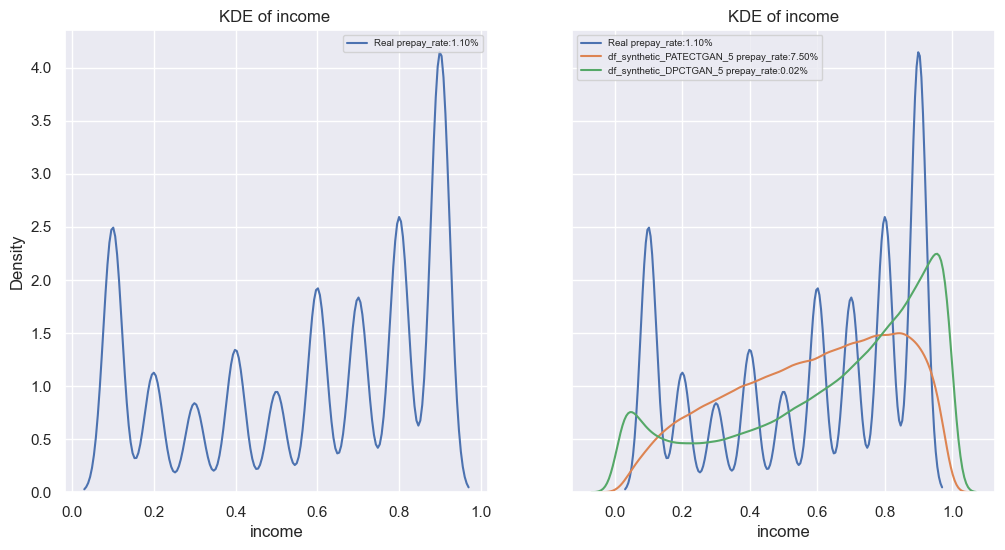

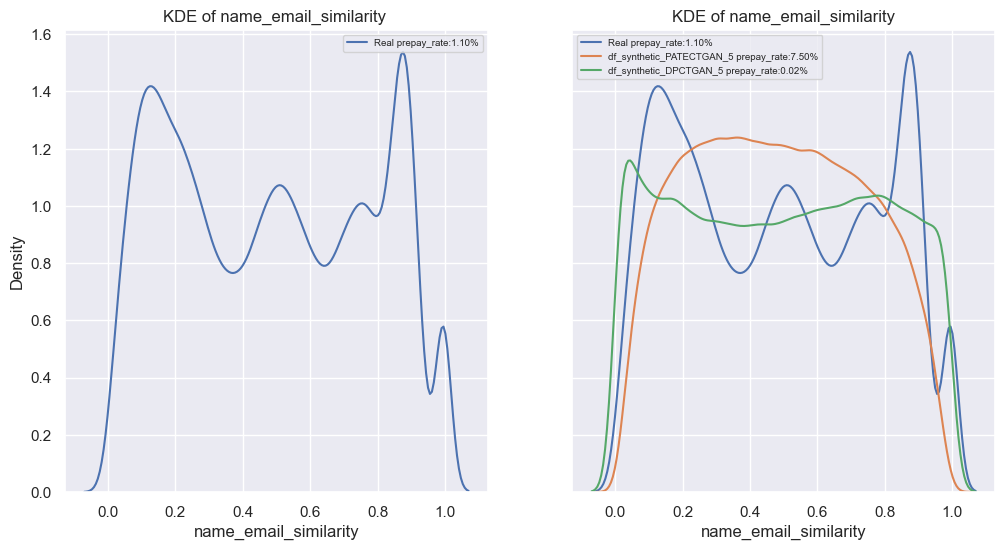

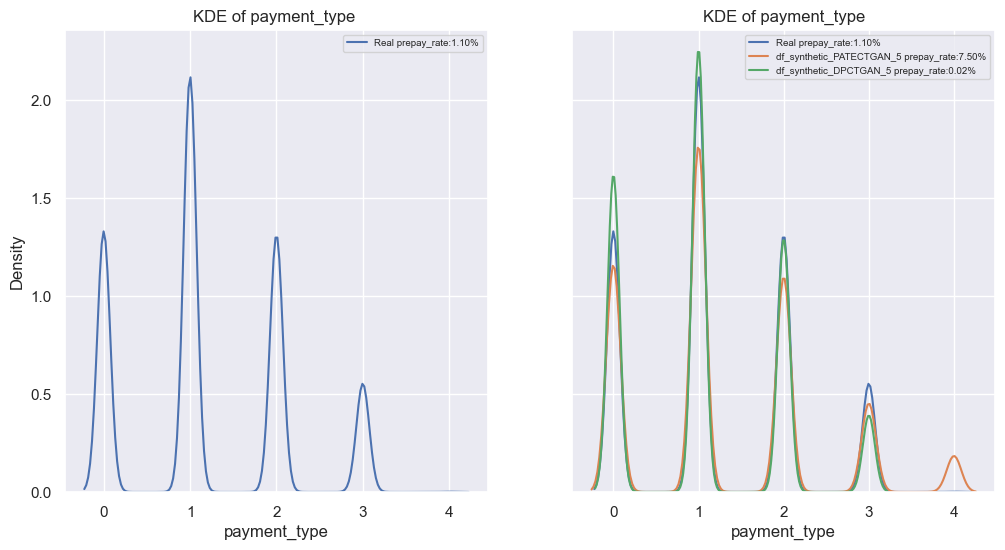

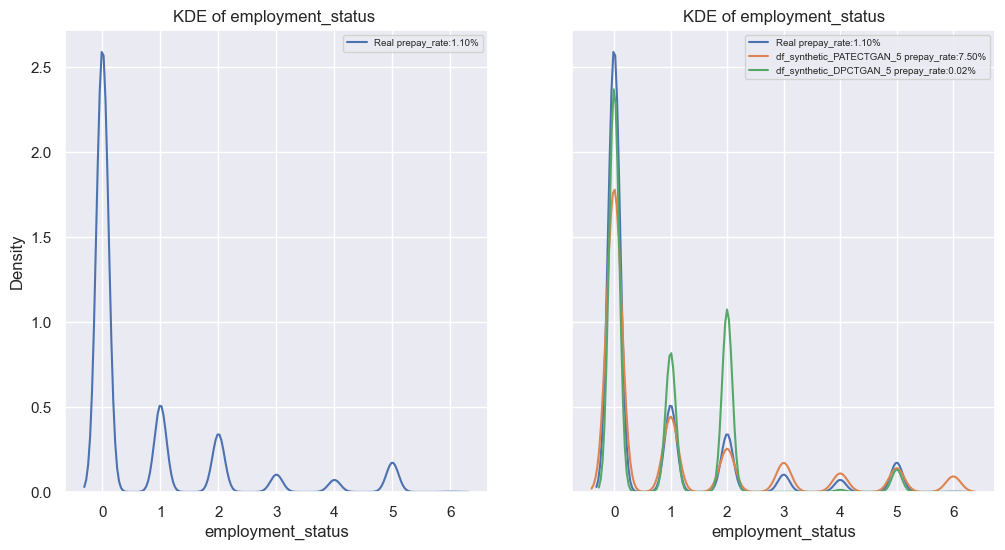

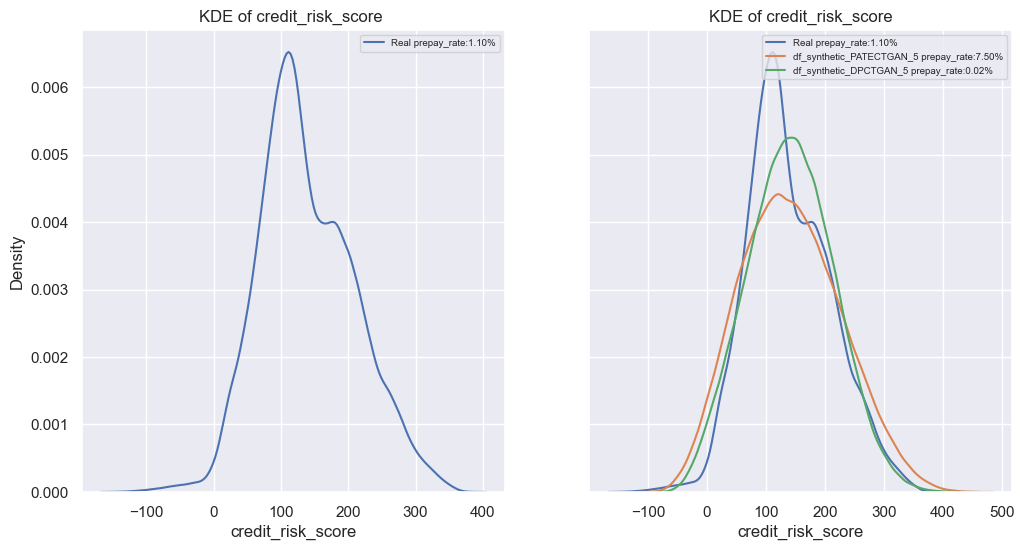

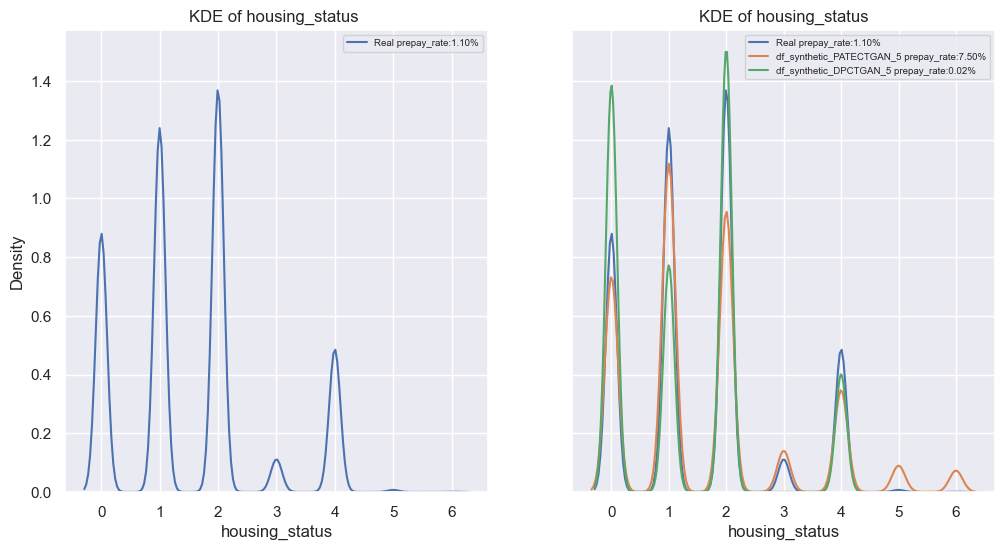

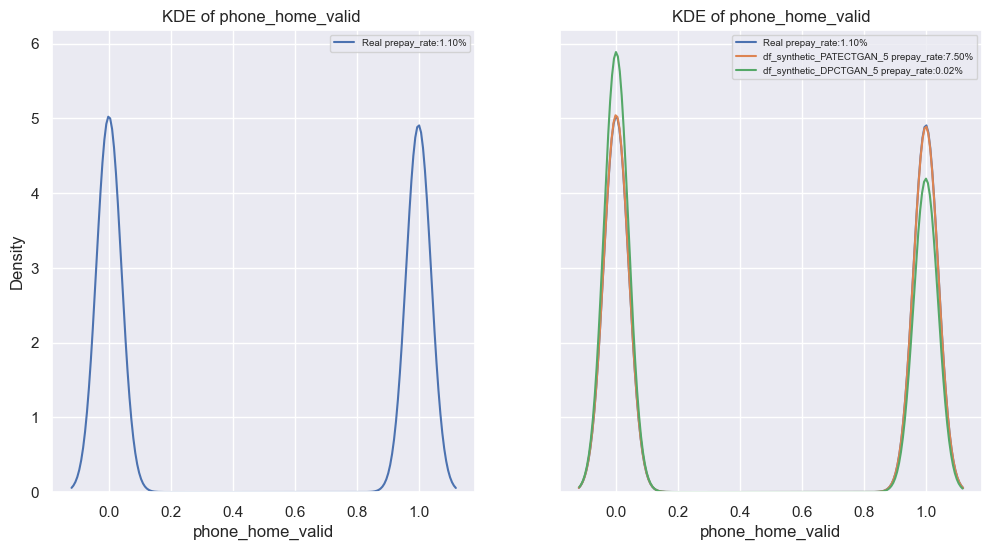

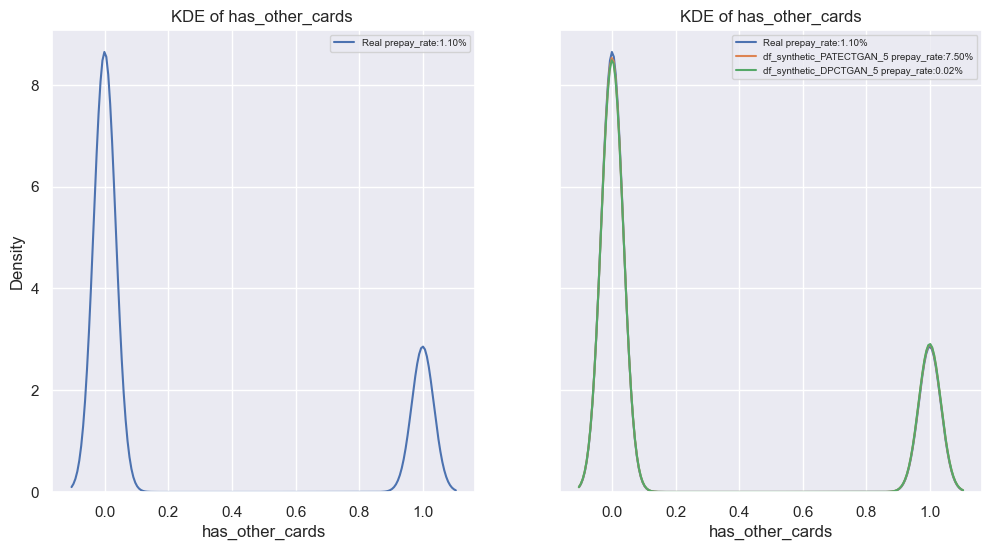

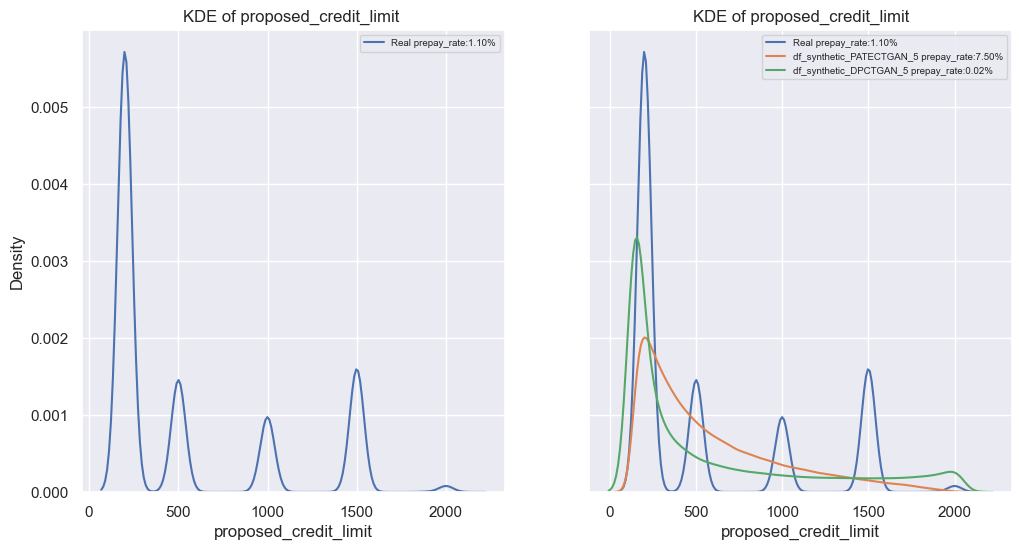

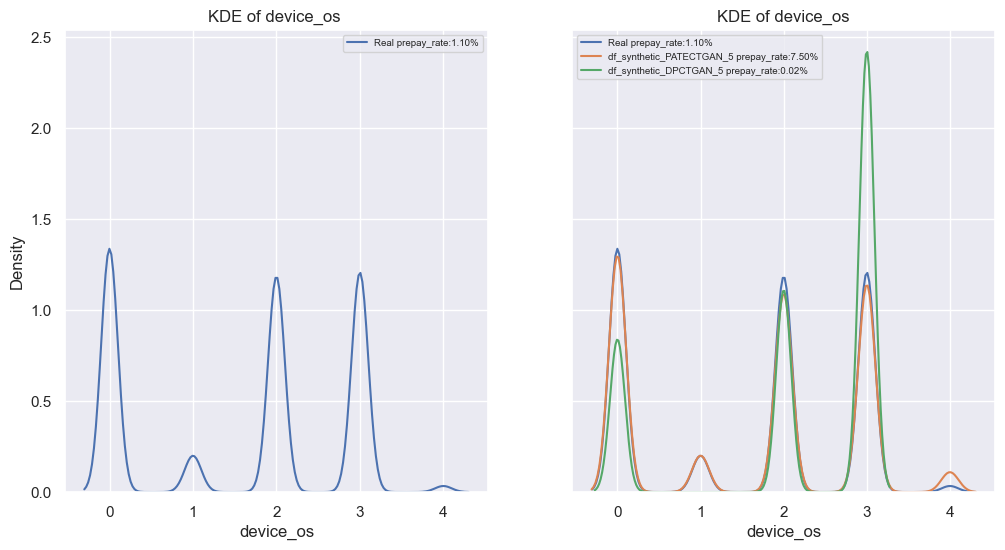

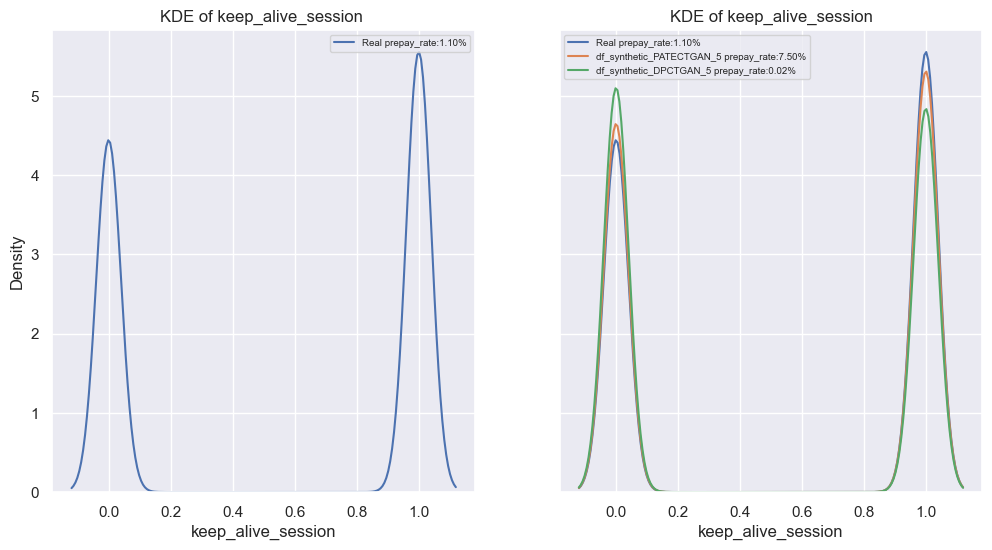

In [28]:
dp_kde_quick(df_real,synth_dict,feature_list)

In [29]:
df_dp_gan = load_log_dpctgan(r"data/output/DP-CTGAN_3.log")
print(df_dp_gan.shape)

df_pate_gan = load_log_patectgan(r"data/output/PATE-CTGAN_3.log")
print(df_pate_gan.shape)

log_dict = {"loss: cross_entropy depth: 1.0 DPGAN":df_dp_gan,
          "loss: cross_entropy depth: 1.0 PATE-CTGAN":df_pate_gan}

#log_dict = {"loss: cross_entropy depth: 1.0 PATE-CTGAN":df_pate_gan}

(235, 3)
(11, 3)


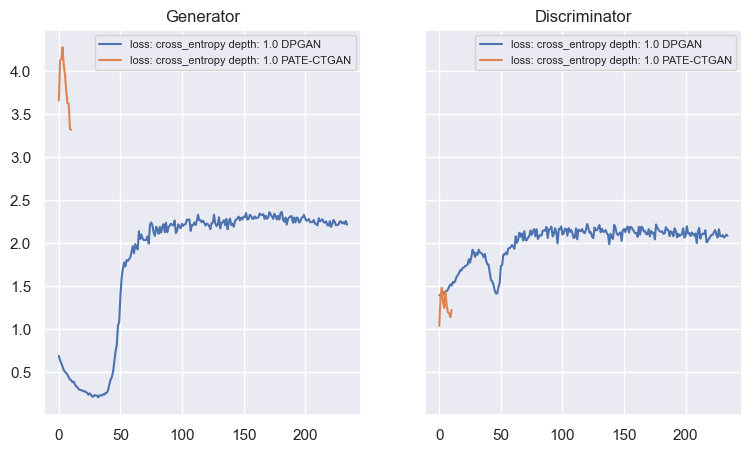

In [30]:
#plot_logs(log_dict, "loss: cross_entropy")
plot_logs(log_dict)